# PROYECTO MACHINE LEARNING - DATA SCIENCE BOOTCAMP


Proyecto orientado a la elaboración de un modelo machine learning relacionado con el mundo bancario

# TEMA: Detectar Deafults en un Banco

Detectar cuando un cliente va a tener problemas para pagar un préstamo y poder predecir impagos y e insolvencia es muy importante para la gestión de riesgos del banco. 

Vamos a elaborar un modelo que replique la identificación de impagos.
Para ello vamos a emplear una dataset de un banco Checo con suficiente información sobre transacciones, préstamos e información de clientes totalmente anonimizado

Los datos los sacamos del siguiente link: https://relational.fit.cvut.cz/dataset/Financial

Seguimos las instrucciones para descargar el dataset y poder trabajar

## Índice

1. [Descripción de los datos](#descr)
2. [Importación de la base de datos](#imp)
3. [Identificación de las variables clave](#clave)
4. [Lista final](#fin)
5. [Correlaciones](#col)
6. [Transformaciones](#trans)
7. [Modeling](#mode)
8. [Observaciones](#ob)

<a name='descr'></a>
## 1. Descripción de los datos

Los datos son los siguientes:

- Cuenta (4500 objetos en el archivo account) - cada registro describe las características estáticas de una cuenta.
- Cliente (5369 objetos en el fichero client): cada registro describe las características de un cliente.
- Disposición (5369 objetos en el fichero disp) - cada registro relaciona un cliente con una cuenta, es decir, esta relación describe los derechos de los clientes a operar con las cuentas.
- Orden (6471 objetos en el fichero order) - cada registro describe las características de una orden de pago.
- Transacción (1056320 objetos en el fichero trans) - cada registro describe una transacción en una cuenta.
- Préstamo (682 objetos en el fichero loan) - cada registro describe un préstamo concedido para una cuenta determinada.
- Tarjeta de crédito (892 objetos en el fichero card) - cada registro describe una tarjeta de crédito concedida a una cuenta.
- Datos demográficos (77 objetos en el fichero district) - cada registro describe las características demográficas de un distrito.

<a name='imp'></a>
## 2. Importación de la base de datos

In [1]:
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
database_host = 'relational.fit.cvut.cz'
username = 'guest'
password = 'relational'
database_name = 'financial'

db = pymysql.connect(host = database_host,
                     user = username,
                     password = password,
                     database = database_name)

Comprobamos el correcto importe de los datos con un ejemplo

In [3]:
query = "SELECT * FROM loan"
df = pd.read_sql(query,db)
df 

,loan_id,account_id,date,amount,duration,payments,status
0,4959,2,1994-01-05,80952,24,3373.0,A
1,4961,19,1996-04-29,30276,12,2523.0,B
2,4962,25,1997-12-08,30276,12,2523.0,A
3,4967,37,1998-10-14,318480,60,5308.0,D
4,4968,38,1998-04-19,110736,48,2307.0,C
...,...,...,...,...,...,...,...
677,7294,11327,1998-09-27,39168,24,1632.0,C
678,7295,11328,1998-07-18,280440,60,4674.0,C
679,7304,11349,1995-10-29,419880,60,6998.0,C
680,7305,11359,1996-08-06,54024,12,4502.0,A


<a name='clave'></a>
## 3. Identificación de las variables clave

Dado que la predicción del impago del préstamo es un problema de clasificación binaria, primero necesitamos saber cuántos valores hay en cada clase. 

Observando la variable de estado en la tabla Préstamo, hay 4 valores distintos: A, B, C y D.

- A: Contrato finalizado, sin problemas.
- B: Contrato terminado, préstamo no pagado.
- C: Contrato en ejecución, bien hasta ahora.
- D: Contrato en marcha, cliente endeudado.

Según las definiciones de la descripción del conjunto de datos, podemos dividirlos en clases binarias: corriente (A o C) y default (B o D). Hay 606 préstamos que entran en la clase "corriente" y 76 de ellos en la clase "default".

In [4]:
query='''
SELECT *
FROM loan
JOIN account
ON loan.account_id = account.account_id
'''

dff=pd.read_sql(query,db)
dff.sample(10)

,loan_id,account_id,date,amount,duration,payments,status,account_id,district_id,frequency,date
516,6766,8784,1998-04-28,74352,24,3098.0,C,8784,1,POPLATEK MESICNE,1996-10-16
602,7061,10105,1994-08-27,121896,24,5079.0,A,10105,55,POPLATEK MESICNE,1993-04-28
309,6073,5263,1996-11-12,276300,60,4605.0,C,5263,64,POPLATEK MESICNE,1995-07-14
51,5154,993,1998-07-01,108720,60,1812.0,C,993,6,POPLATEK MESICNE,1996-11-14
202,5693,3489,1995-08-01,44088,24,1837.0,A,3489,9,POPLATEK MESICNE,1994-12-08
407,6442,7082,1998-02-08,194160,48,4045.0,C,7082,57,POPLATEK MESICNE,1996-09-06
350,6223,5991,1994-11-03,61056,48,1272.0,A,5991,1,POPLATEK MESICNE,1993-11-21
425,6509,7445,1994-03-15,55368,24,2307.0,A,7445,64,POPLATEK MESICNE,1993-03-18
512,6755,8713,1998-07-24,170700,60,2845.0,C,8713,53,POPLATEK MESICNE,1997-05-18
371,6297,6363,1994-10-25,17508,12,1459.0,A,6363,74,POPLATEK MESICNE,1993-08-01


In [5]:
dff_corriente = df.loc[(df['status'] == 'A') | (df['status'] == 'C')]
dff_default = df.loc[(df['status'] == 'B') | (df['status'] == 'D')]

In [6]:
dff_corriente.shape[0]

606

In [7]:
dff_default.shape[0]

76

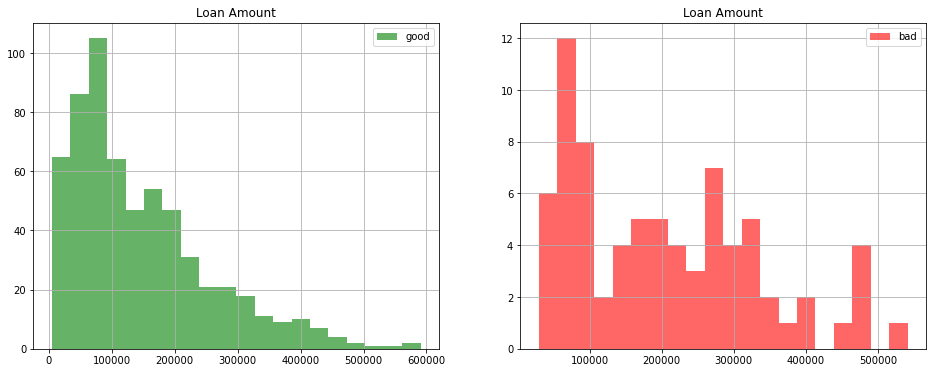

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
dff_corriente.amount.hist(bins=20, ax=ax1, label='good', color='green', alpha=0.6)
dff_default.amount.hist(bins=20, ax=ax2, label='bad', color='red', alpha=0.6)
ax1.set_title('Loan Amount')
ax2.set_title('Loan Amount')
ax1.legend()
ax2.legend()
plt.show()

Podemos observar que a mayor importe de los préstamos, mayores impagos suceden.

Variables cable para tabla final:
   - loan amount
   - loan duration
   - loan payment
   - account district id
   - frequency
   - date loan issued
   - date account opened
   - days between

**De Préstamo, Cuenta y Datos demográficos**

In [9]:
query = '''
SELECT  loan.account_id,
        loan.date as date_loan,
        amount,
        duration,
        payments,
        status,
        frequency,
        account.date as date_acc,
        A4, A11, A12, A13, A14, A15, A16
FROM loan
JOIN account
ON loan.account_id = account.account_id
JOIN district
ON account.district_id = district.district_id
'''

df = pd.read_sql(query,db)

In [10]:
df['date_loan'] = pd.to_datetime(df.date_loan, format='%Y-%m-%d')
df['date_acc'] = pd.to_datetime(df.date_acc, format='%Y-%m-%d')
df['days_between'] = (df['date_loan'] - df['date_acc']).dt.days
df['n_inhabitants'] = df.A4
df['average_salary'] = df.A11
df['average_unemployment_rate'] = df[['A12', 'A13']].mean(axis=1)
df['entrepreneur_rate'] = df['A14']
df['average_crime_rate'] = df[['A15', 'A16']].mean(axis=1) / df['n_inhabitants']
df['default'] = (df['status'] == 'B') | (df['status'] == 'D')
df

,account_id,date_loan,amount,duration,payments,status,frequency,date_acc,A4,A11,...,A14,A15,A16,days_between,n_inhabitants,average_salary,average_unemployment_rate,entrepreneur_rate,average_crime_rate,default
0,2,1994-01-05,80952,24,3373.0,A,POPLATEK MESICNE,1993-02-26,1204953,12541,...,167,85677.0,99107,313,1204953,12541,0.315,167,0.076677,False
1,19,1996-04-29,30276,12,2523.0,B,POPLATEK MESICNE,1995-04-07,103347,9104,...,123,2299.0,2354,388,103347,9104,1.785,123,0.022512,True
2,25,1997-12-08,30276,12,2523.0,A,POPLATEK MESICNE,1996-07-28,228848,9893,...,96,5623.0,5887,498,228848,9893,4.360,96,0.025148,False
3,37,1998-10-14,318480,60,5308.0,D,POPLATEK MESICNE,1997-08-18,70646,8547,...,120,1563.0,1542,422,70646,8547,3.120,120,0.021976,True
4,38,1998-04-19,110736,48,2307.0,C,POPLATEK TYDNE,1997-08-08,51428,8402,...,120,999.0,1099,254,51428,8402,3.540,120,0.020397,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,11327,1998-09-27,39168,24,1632.0,C,POPLATEK MESICNE,1997-10-15,94725,9920,...,130,4289.0,4846,347,94725,9920,2.535,130,0.048219,False
678,11328,1998-07-18,280440,60,4674.0,C,POPLATEK MESICNE,1996-11-05,387570,9897,...,140,18721.0,18696,620,387570,9897,1.780,140,0.048271,False
679,11349,1995-10-29,419880,60,6998.0,C,POPLATEK TYDNE,1995-05-26,1204953,12541,...,167,85677.0,99107,156,1204953,12541,0.315,167,0.076677,False
680,11359,1996-08-06,54024,12,4502.0,A,POPLATEK MESICNE,1994-10-01,117897,8814,...,107,2112.0,2059,675,117897,8814,5.220,107,0.017689,False


**De Transacción**

In [11]:
query = '''
select trans.account_id, trans.amount as trans_amount, balance as trans_balance 
from trans
join loan
on trans.account_id = loan.account_id
and trans.date < loan.date
'''
df_trans = pd.read_sql(query,db)
df_trans

,account_id,trans_amount,trans_balance
0,2,1100,1100
1,2,20236,21336
2,2,20236,45286
3,2,20236,54631
4,2,30354,67530
...,...,...,...
54689,11362,93,17922
54690,11362,75,14889
54691,11362,73,15993
54692,11362,87,19331


In [12]:
n_trans = df_trans[['account_id', 'trans_amount']].groupby('account_id',as_index=False).count()
n_trans.columns = ['account_id', 'n_trans']
n_trans

,account_id,n_trans
0,2,54
1,19,80
2,25,164
3,37,116
4,38,55
...,...,...
677,11327,54
678,11328,106
679,11349,18
680,11359,147


In [13]:
df_trans2 = df_trans.groupby('account_id',as_index=False).mean()
df_trans2

,account_id,trans_amount,trans_balance
0,2,7954.333333,32590.759259
1,19,5856.350000,25197.137500
2,25,12113.981707,62991.408537
3,37,7572.034483,39954.034483
4,38,4716.200000,31383.581818
...,...,...,...
677,11327,7977.981481,55438.814815
678,11328,8138.754717,38619.084906
679,11349,24426.500000,59352.666667
680,11359,8708.775510,36480.238095


In [14]:
df = df.merge(df_trans2,how='left',left_on='account_id',right_on='account_id').merge(n_trans,how='left',left_on='account_id',right_on='account_id')
df

,account_id,date_loan,amount,duration,payments,status,frequency,date_acc,A4,A11,...,days_between,n_inhabitants,average_salary,average_unemployment_rate,entrepreneur_rate,average_crime_rate,default,trans_amount,trans_balance,n_trans
0,2,1994-01-05,80952,24,3373.0,A,POPLATEK MESICNE,1993-02-26,1204953,12541,...,313,1204953,12541,0.315,167,0.076677,False,7954.333333,32590.759259,54
1,19,1996-04-29,30276,12,2523.0,B,POPLATEK MESICNE,1995-04-07,103347,9104,...,388,103347,9104,1.785,123,0.022512,True,5856.350000,25197.137500,80
2,25,1997-12-08,30276,12,2523.0,A,POPLATEK MESICNE,1996-07-28,228848,9893,...,498,228848,9893,4.360,96,0.025148,False,12113.981707,62991.408537,164
3,37,1998-10-14,318480,60,5308.0,D,POPLATEK MESICNE,1997-08-18,70646,8547,...,422,70646,8547,3.120,120,0.021976,True,7572.034483,39954.034483,116
4,38,1998-04-19,110736,48,2307.0,C,POPLATEK TYDNE,1997-08-08,51428,8402,...,254,51428,8402,3.540,120,0.020397,False,4716.200000,31383.581818,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,11327,1998-09-27,39168,24,1632.0,C,POPLATEK MESICNE,1997-10-15,94725,9920,...,347,94725,9920,2.535,130,0.048219,False,7977.981481,55438.814815,54
678,11328,1998-07-18,280440,60,4674.0,C,POPLATEK MESICNE,1996-11-05,387570,9897,...,620,387570,9897,1.780,140,0.048271,False,8138.754717,38619.084906,106
679,11349,1995-10-29,419880,60,6998.0,C,POPLATEK TYDNE,1995-05-26,1204953,12541,...,156,1204953,12541,0.315,167,0.076677,False,24426.500000,59352.666667,18
680,11359,1996-08-06,54024,12,4502.0,A,POPLATEK MESICNE,1994-10-01,117897,8814,...,675,117897,8814,5.220,107,0.017689,False,8708.775510,36480.238095,147


**De Tarjeta de Crédito**

In [15]:
query='''
select disp.account_id, card.type as card_type

from card
join disp 
on card.disp_id = disp.disp_id
join loan
on disp.account_id = loan.account_id
and card.issued < loan.date
WHERE disp.type = 'OWNER'
'''
df_card = pd.read_sql(query,db)
df_card

,account_id,card_type
0,105,classic
1,226,classic
2,276,classic
3,544,classic
4,666,classic
5,1480,classic
6,1766,classic
7,1869,classic
8,2116,classic
9,2262,classic


In [16]:
df = df.merge(df_card, how='left', left_on='account_id',right_on='account_id')
df['card_type'].fillna('No',inplace=True)
df

,account_id,date_loan,amount,duration,payments,status,frequency,date_acc,A4,A11,...,n_inhabitants,average_salary,average_unemployment_rate,entrepreneur_rate,average_crime_rate,default,trans_amount,trans_balance,n_trans,card_type
0,2,1994-01-05,80952,24,3373.0,A,POPLATEK MESICNE,1993-02-26,1204953,12541,...,1204953,12541,0.315,167,0.076677,False,7954.333333,32590.759259,54,No
1,19,1996-04-29,30276,12,2523.0,B,POPLATEK MESICNE,1995-04-07,103347,9104,...,103347,9104,1.785,123,0.022512,True,5856.350000,25197.137500,80,No
2,25,1997-12-08,30276,12,2523.0,A,POPLATEK MESICNE,1996-07-28,228848,9893,...,228848,9893,4.360,96,0.025148,False,12113.981707,62991.408537,164,No
3,37,1998-10-14,318480,60,5308.0,D,POPLATEK MESICNE,1997-08-18,70646,8547,...,70646,8547,3.120,120,0.021976,True,7572.034483,39954.034483,116,No
4,38,1998-04-19,110736,48,2307.0,C,POPLATEK TYDNE,1997-08-08,51428,8402,...,51428,8402,3.540,120,0.020397,False,4716.200000,31383.581818,55,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,11327,1998-09-27,39168,24,1632.0,C,POPLATEK MESICNE,1997-10-15,94725,9920,...,94725,9920,2.535,130,0.048219,False,7977.981481,55438.814815,54,No
678,11328,1998-07-18,280440,60,4674.0,C,POPLATEK MESICNE,1996-11-05,387570,9897,...,387570,9897,1.780,140,0.048271,False,8138.754717,38619.084906,106,No
679,11349,1995-10-29,419880,60,6998.0,C,POPLATEK TYDNE,1995-05-26,1204953,12541,...,1204953,12541,0.315,167,0.076677,False,24426.500000,59352.666667,18,No
680,11359,1996-08-06,54024,12,4502.0,A,POPLATEK MESICNE,1994-10-01,117897,8814,...,117897,8814,5.220,107,0.017689,False,8708.775510,36480.238095,147,classic


<a name='fin'></a>
## 4. Lista Final

In [17]:
df_ml = df[['amount', 'duration', 'payments', 'days_between', 'n_inhabitants', 
            'average_salary', 'average_unemployment_rate', 'entrepreneur_rate', 
            'average_crime_rate', 'n_trans',
            'frequency', 'card_type', 'default']]
df_ml

,amount,duration,payments,days_between,n_inhabitants,average_salary,average_unemployment_rate,entrepreneur_rate,average_crime_rate,n_trans,frequency,card_type,default
0,80952,24,3373.0,313,1204953,12541,0.315,167,0.076677,54,POPLATEK MESICNE,No,False
1,30276,12,2523.0,388,103347,9104,1.785,123,0.022512,80,POPLATEK MESICNE,No,True
2,30276,12,2523.0,498,228848,9893,4.360,96,0.025148,164,POPLATEK MESICNE,No,False
3,318480,60,5308.0,422,70646,8547,3.120,120,0.021976,116,POPLATEK MESICNE,No,True
4,110736,48,2307.0,254,51428,8402,3.540,120,0.020397,55,POPLATEK TYDNE,No,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,39168,24,1632.0,347,94725,9920,2.535,130,0.048219,54,POPLATEK MESICNE,No,False
678,280440,60,4674.0,620,387570,9897,1.780,140,0.048271,106,POPLATEK MESICNE,No,False
679,419880,60,6998.0,156,1204953,12541,0.315,167,0.076677,18,POPLATEK TYDNE,No,False
680,54024,12,4502.0,675,117897,8814,5.220,107,0.017689,147,POPLATEK MESICNE,classic,False


In [18]:
df_ml.sample(10)


,amount,duration,payments,days_between,n_inhabitants,average_salary,average_unemployment_rate,entrepreneur_rate,average_crime_rate,n_trans,frequency,card_type,default
190,68124,12,5677.0,320,323870,10673,5.070,100,0.057321,51,POPLATEK MESICNE,No,False
527,50112,24,2088.0,108,162580,9538,1.655,111,0.035333,16,POPLATEK MESICNE,No,False
120,71460,36,1985.0,240,1204953,12541,0.315,167,0.076677,31,POPLATEK MESICNE,No,False
52,188532,36,5237.0,648,285387,10177,7.175,81,0.035016,148,POPLATEK MESICNE,No,False
568,46176,48,962.0,161,145688,8544,1.530,109,0.019305,17,POPLATEK MESICNE,No,False
267,402000,60,6700.0,315,149893,9753,4.825,109,0.037146,54,POPLATEK MESICNE,No,False
203,174840,60,2914.0,389,109164,8757,3.625,96,0.021449,87,POPLATEK MESICNE,No,False
368,85632,48,1784.0,494,197099,9624,1.955,145,0.022194,85,POPLATEK MESICNE,No,False
160,156420,60,2607.0,344,139012,8363,2.995,108,0.019290,63,POPLATEK TYDNE,No,False
608,239160,60,3986.0,437,67298,8561,0.945,110,0.016018,106,POPLATEK MESICNE,No,False


<a name='col'></a>
## 5. Correlaciones

Comprobamos rapidamente la correlacion entre las variables:

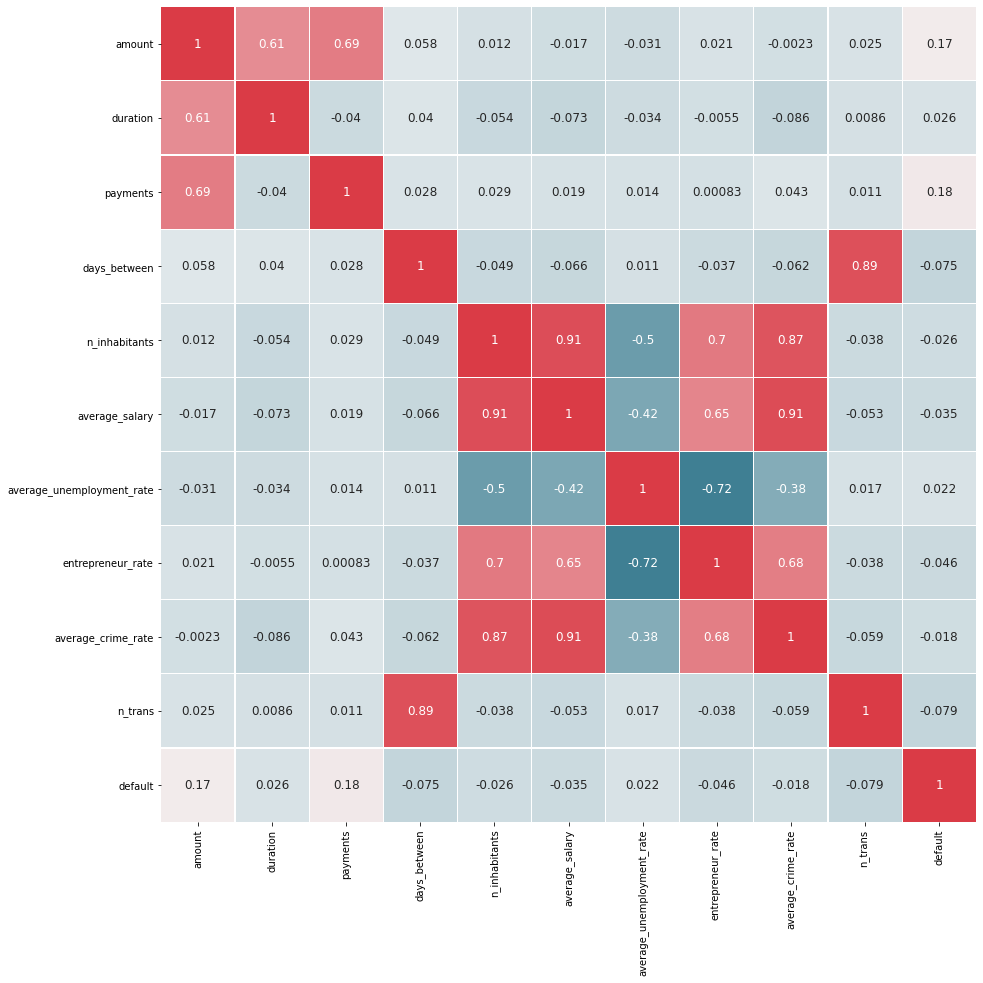

In [19]:
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(
        df_ml.corr(), 
        cmap = sns.diverging_palette(220, 10, as_cmap = True),
        square=True, 
        cbar=False,
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 })
plt.show()

<a name='trans'></a>
## 6. Transformaciones

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [21]:
df_ml2 = pd.get_dummies(df_ml,columns=['frequency','card_type'])
df_ml2['default'] = df_ml2.default.astype('int')
df_ml2.head()

,amount,duration,payments,days_between,n_inhabitants,average_salary,average_unemployment_rate,entrepreneur_rate,average_crime_rate,n_trans,default,frequency_POPLATEK MESICNE,frequency_POPLATEK PO OBRATU,frequency_POPLATEK TYDNE,card_type_No,card_type_classic,card_type_gold,card_type_junior
0,80952,24,3373.0,313,1204953,12541,0.315,167,0.076677,54,0,1,0,0,1,0,0,0
1,30276,12,2523.0,388,103347,9104,1.785,123,0.022512,80,1,1,0,0,1,0,0,0
2,30276,12,2523.0,498,228848,9893,4.360,96,0.025148,164,0,1,0,0,1,0,0,0
3,318480,60,5308.0,422,70646,8547,3.120,120,0.021976,116,1,1,0,0,1,0,0,0
4,110736,48,2307.0,254,51428,8402,3.540,120,0.020397,55,0,0,0,1,1,0,0,0


<a name='mode'></a>
## 7. Modeling

Hay que tener en cuenta que nuestro conjunto de datos tiene casi 10 veces mas préstamos al corriente de pago que en default

In [22]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, plot_confusion_matrix, plot_roc_curve

En este caso vamos a elegir el modelo de aprendizaje Random Forest por su buen rendimiento y capacidad de creación rapida de prototipos. 

Vamos a utilizar tres medidas distintas: precision, puntuacion F1 y AUC ROC

In [23]:
X = df_ml2.drop(columns=['default'])
y = df_ml2['default']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)

In [25]:
clf = RandomForestClassifier(random_state=10)
print('Acc:', cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='accuracy').mean())
print('F1:', cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='f1').mean())
print('ROC AUC:', cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='roc_auc').mean())

Acc: 0.8910087719298245
F1: 0.15934065934065936
ROC AUC: 0.6690101858925388


Podemos observar que la precisión es muy alta (casi 0,9).
Por el contrario F1 es demasiado bajo.

Por lo tanto podemos realizar un ajuste para conseguir un mejor rendimiento y para ello utilizamos GridSearch

In [26]:
params = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

In [27]:
clf = GridSearchCV(RandomForestClassifier(random_state=10), param_grid=params, 
                   cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=10), scoring='f1')
clf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
             estimator=RandomForestClassifier(random_state=10),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100, 200]},
             scoring='f1')

In [28]:
print(clf.best_params_)

{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [29]:
clf.best_score_

0.1682051282051282

Observamos que con este ajuste ha subido levemente

In [30]:
clf = RandomForestClassifier(n_estimators=10,
                             max_depth=None,
                             min_samples_split=5,
                             min_samples_leaf=1,
                             random_state=11)

In [31]:
clf.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=5, n_estimators=10, random_state=11)

**RENDIMIENTO TRAIN SET**

In [32]:
y_train_pred = clf.predict(X_train)
y_train_proba = clf.predict_proba(X_train)

In [33]:
print('Train Acc:', accuracy_score(y_train, y_train_pred))
print('Train F1:', f1_score(y_train, y_train_pred))
print('Train ROC AUC:', roc_auc_score(y_train, y_train_proba[:, 1]))

Train Acc: 0.9559748427672956
Train F1: 0.7529411764705882
Train ROC AUC: 0.9923460306158776


Matriz de confusión

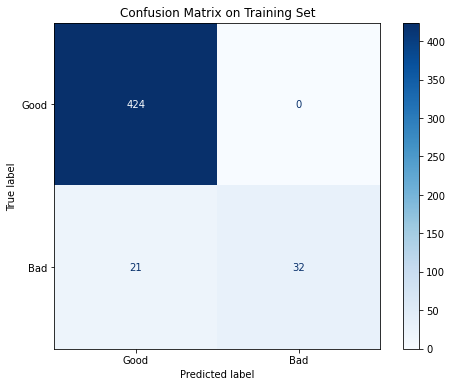

In [34]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_confusion_matrix(clf, X_train, y_train, display_labels=['Good', 'Bad'], 
                      cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix on Training Set')
plt.show()

**RENDIMIENTO TEST SET**

In [35]:
y_test_pred = clf.predict(X_test)
y_test_proba = clf.predict_proba(X_test)

In [36]:
print('test Acc:', accuracy_score(y_test, y_test_pred))
print('test F1:', f1_score(y_test, y_test_pred))
print('test ROC AUC:', roc_auc_score(y_test, y_test_proba[:, 1]))


test Acc: 0.8731707317073171
test F1: 0.0
test ROC AUC: 0.5702341137123745


Matriz de confusión

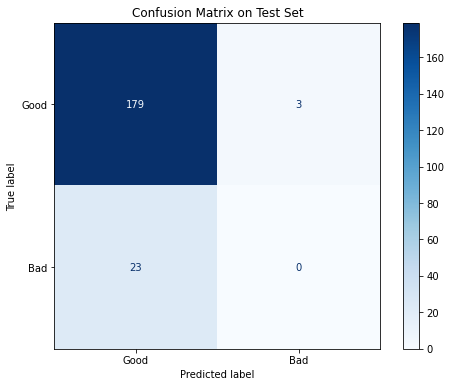

In [37]:
Fig, ax = plt.subplots(figsize=(8, 6))
plot_confusion_matrix(clf, X_test, y_test, display_labels=['Good', 'Bad'], 
                      cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix on Test Set')
plt.show()

Curva ROC

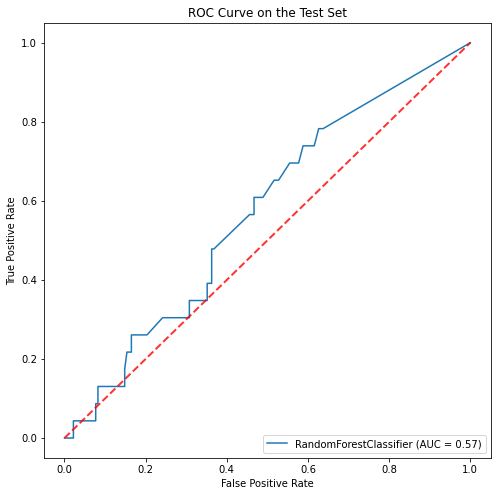

In [38]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_roc_curve(clf, X_test, y_test, ax=ax)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
ax.set_title('ROC Curve on the Test Set')
plt.show()

**Top 5 variables con mayor importancia para predecir impagos**

In [42]:
np.sum(clf.feature_importances_) 

1.0

In [56]:
feature_list = list(df_ml.columns)
feature_list

['amount',
 'duration',
 'payments',
 'days_between',
 'n_inhabitants',
 'average_salary',
 'average_unemployment_rate',
 'entrepreneur_rate',
 'average_crime_rate',
 'n_trans',
 'frequency',
 'card_type',
 'default']

In [57]:
import_dict = {'features': feature_list,
              'importance':clf.feature_importances_}
pd.DataFrame(import_dict).sort_values('importance', ascending=False)

ValueError: arrays must all be same length

<a name='ob'></a>
## 8. Observaciones

En este trabajo se ha realizado un modelo de aprendizaje automático de aplicacion bancaria.
Se ha descrito el conjunto de datos, identificando las variables cable.
Se ha ido paso a paso desde la importacion de los datos hasta el modelado, utilizando MySQL conectado a Python, y varias librerias de esta para poder llevar a cabo el trabajo.
Se han extraido las variables cable y formado un tablón final para su desarrollo y aprendizaje.
Se ha utilizado el modelo Random Forest de metodo supervisado y obtenido una lista con las 5 principales variables que influyen en el impago de los clientes. 

Como área de mejora del trabajo, se podría profundizar en la extraccion de mas variables para obtener una mejor idea de como variables que no han sido utilizadas pueden afectar y modificar los resultados; emplear otro tipo de modelo mas complejo ya sea redes neuronales; y emplear mas datos en situacion de default ya que en la base empleada en torno al 10% del total estaban en situación de impago